# SPIFT Tutorial
Authors: Karan Luthria, Paula Josefine Schultheiss
Izar Lab, CUIMC

This is a **SPIFT Tutorial** - This notebook will guide you through a demo of SPiFT (Stiffness Profiling Integrated with Functional Transcriptomics).

---

## 1. Introduction

SPIFT integrates Atomic Force Microscopy Reads with Spatial Transcriptomics and snRNA-seq methods, as a way of estimating the stifffnes of the enviornment surrounding single cells.

---

## 2. Setup and Requirements

This tutorial was run using the following package versions listed in the accompaning `package_versions.txt` file. Please note that you are using these version numbers to avoid any unexpected errors.


## 3. Required Input Files and Formatting

The data used for this tutorial are stored in `lib/`

`AFM_cropped.tif` is a tif image of the AFM Microscopy Tissue Section generated by the calibration script, cropped to fit the region of interest

`Visium_H&E.tif` is a tif image of the H&E stained tissue section used for Visium HD, cropped to fit the region of interest


## Load Helper Functions and Required Packages

In [ ]:
import cv2
import numpy as np
from skimage import io
from pystackreg import StackReg
import pandas as pd
import scanpy as sc
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import multiprocessing as mp
import torch
import squidpy as sq
from scipy.spatial import cKDTree


/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def overlay_images(imgs, equalize=False, aggregator=np.mean):
    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]
    imgs = np.stack(imgs, axis=0)
    return aggregator(imgs, axis=0)

def composite_images(imgs, equalize=False, aggregator=np.mean):
    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]
    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))
    imgs = np.dstack(imgs)
    return imgs

def show_transformation(tmat, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    p = np.array([[1,120,1], [1,1,1], [250, 1, 1], [250,120,1], [1,120,1]])
    ax.plot(p[:, 0], p[:,1])
    q=np.dot(p, tmat.T)
    ax.plot(q[:, 0], q[:,1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend(['Original image', 'transformed image'])


def apply_transformation(row, sr):
    # Extract X and Y coordinates from the row
    x_ref, y_ref = row["X"], row["Y"]

    # Create a homogenous coordinate
    coordinate_ref = np.array([x_ref, y_ref, 1])

    # Apply the transformation matrix obtained from StackReg
    transformed_coordinate_mov = np.dot(sr.get_matrix(), coordinate_ref)

    # Extract the transformed X and Y coordinates
    x_mov, y_mov, _ = transformed_coordinate_mov

    # Update the row with the transformed coordinates
    row["X"], row["Y"] = x_mov, y_mov

    return row

## Define Inputs and Constants

In [5]:
prefix = "lib/"


#The original AFM cropped image, cropped to the region of interest
canvas2 = cv2.imread(prefix + "AFM_cropped.tif", cv2.IMREAD_GRAYSCALE)

afm_load = pd.read_csv(prefix + "afm-072326.csv")


#SpaceRanger Output
path = "lib/spatial/outs/"
adata = sq.read.visium(path)

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Preprocess and Plot Visium H&E

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/tmp/ipykernel_197155/24835900.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.

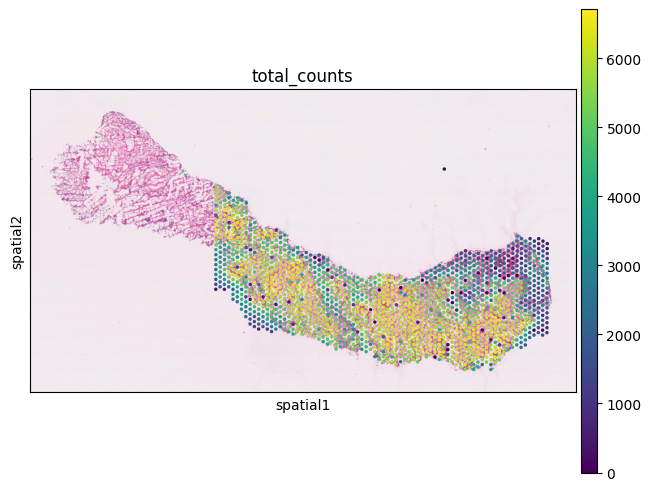

In [6]:
adata = sq.read.visium(path)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs["total_counts"] = adata.X.sum(axis=1)
filtered_adata = adata[adata.obsm['spatial'][:, 0] >= 0].copy()
sq.pl.spatial_scatter(filtered_adata, color="total_counts", size=1.0)

### After loading the Visium H&E image from SpaceRanger, we need to seperate and spatial capture spot coordinates and the H&E image, for later registration

In [7]:
spatial_coords = filtered_adata.obsm['spatial']

# Get the high-resolution image
img = filtered_adata.uns["spatial"][list(filtered_adata.uns["spatial"].keys())[0]]["images"]["hires"]

# Get the scale factors for the spatial data and image
scalefactor = filtered_adata.uns["spatial"][list(filtered_adata.uns["spatial"].keys())[0]]["scalefactors"]["tissue_hires_scalef"]

# Scale spatial coordinates to match the image dimensions
spatial_coords_scaled = spatial_coords * scalefactor

For proper registration, we need to scale the image to take the same shape at the original AFM image

We also need to rotate the image to take on the same orientation as the AFM image

Finally, all transformations done to the image need to be applied to the coordinates to match

This code block should be adjusted from use case to use case to match and be overlayed with AFM input image

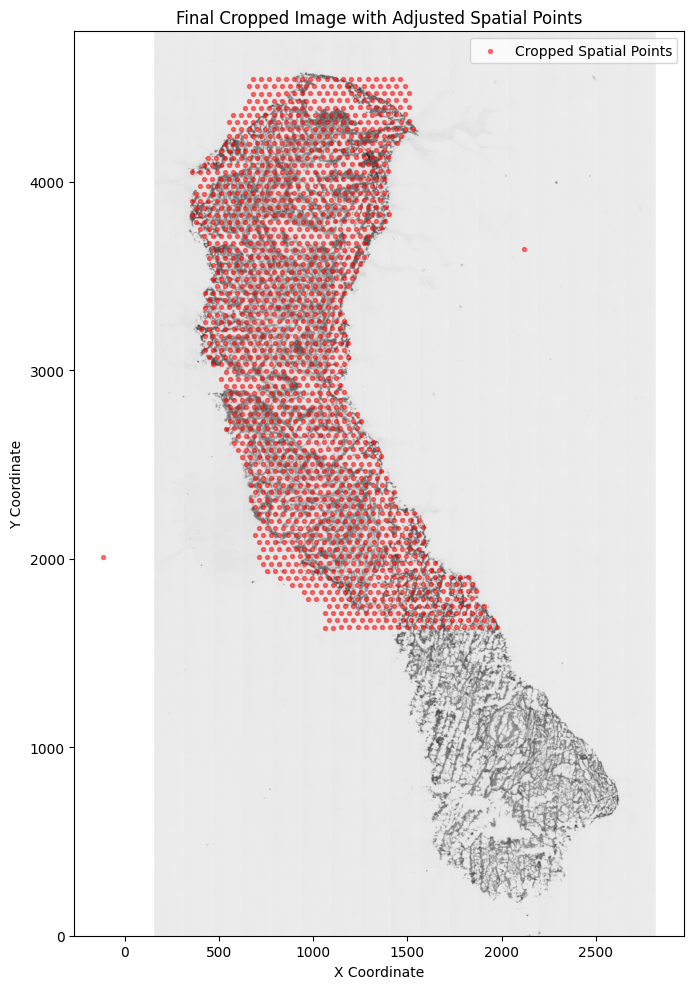

In [9]:
spatial_coords = filtered_adata.obsm['spatial']

# Get the high-resolution image
img = filtered_adata.uns["spatial"][list(filtered_adata.uns["spatial"].keys())[0]]["images"]["hires"]

# Get the scale factors for the spatial data and image
scalefactor = filtered_adata.uns["spatial"][list(filtered_adata.uns["spatial"].keys())[0]]["scalefactors"]["tissue_hires_scalef"]

# Scale spatial coordinates to match the image dimensions
spatial_coords_scaled = spatial_coords * scalefactor

# Rotate, resize, and center the image on a white canvas
img_rotated = np.rot90(np.flipud(img))
original_h, original_w = img_rotated.shape[:2]

# Target canvas size
target_size = canvas2.shape[0]
scaling_factor = min(target_size / original_h, target_size / original_w)

# Resize the image while maintaining the aspect ratio
new_h, new_w = int(original_h * scaling_factor), int(original_w * scaling_factor)
img_resized = cv2.resize(img_rotated, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Create a white canvas and center the resized image
canvas = np.full((target_size, target_size), 255, dtype=np.uint8)
top, left = (target_size - new_h) // 2, (target_size - new_w) // 2
canvas[top:top + new_h, left:left + new_w] = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

# Transform and scale spatial coordinates to match the resized image
spatial_coords_transformed = np.column_stack((
    spatial_coords_scaled[:, 1],  # Swap x and y for rotation
    spatial_coords_scaled[:, 0]  # Undo the initial flip
))
spatial_coords_transformed[:, 0] = img.shape[0] - spatial_coords_transformed[:, 0]  # Flip y
spatial_coords_transformed[:, 1] = img.shape[1] - spatial_coords_transformed[:, 1]  # Flip x
spatial_coords_transformed *= scaling_factor
spatial_coords_transformed[:, 0] += left  # Center x
spatial_coords_transformed[:, 1] += top   # Center y

# Rotate the canvas and coordinates 180 degrees
canvas_rotated = np.rot90(canvas, 2)  # Rotate the canvas
spatial_coords_rotated = np.copy(spatial_coords_transformed)
spatial_coords_rotated[:, 0] = target_size - spatial_coords_transformed[:, 0]  # Flip x
spatial_coords_rotated[:, 1] = target_size - spatial_coords_transformed[:, 1]  # Flip y

# Flip the rotated canvas and coordinates on the y-axis
canvas_flipped = np.flip(canvas_rotated, axis=1)
spatial_coords_flipped = np.copy(spatial_coords_rotated)
spatial_coords_flipped[:, 0] = target_size - spatial_coords_rotated[:, 0]  # Flip x again

# Crop the flipped canvas to match the target width
target_width = canvas2.shape[1]
left_crop = (canvas_flipped.shape[1] - target_width) // 2
canvas_cropped = canvas_flipped[:, left_crop:left_crop + target_width]

# Adjust the coordinates to align with the cropped canvas
spatial_coords_cropped = np.copy(spatial_coords_flipped)
spatial_coords_cropped[:, 0] -= left_crop

# Plot the final cropped canvas and adjusted spatial points
plt.figure(figsize=(10, 10))
plt.imshow(canvas_cropped, cmap="gray")
plt.scatter(
    spatial_coords_cropped[:, 0], 
    spatial_coords_cropped[:, 1], 
    s=8, 
    alpha=0.5, 
    color="red", 
    label="Cropped Spatial Points"
)
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.title("Final Cropped Image with Adjusted Spatial Points")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.tight_layout()
plt.show()


The next script will cover the following steps in SPiFT 
1. **Image Preprocessing**: Blurring, edge detection, and dilation.
2. **Image Registration**: Using the `StackReg` library for scaled rotation-based registration.
3. **Transformation Visualization**: Visualizing the transformation matrix applied.


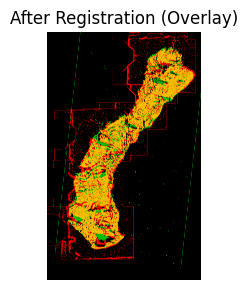

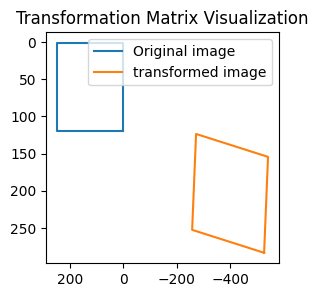

In [10]:
canvas1 = cv2.imread(prefix + "Visium_H&E.tif", cv2.IMREAD_GRAYSCALE)

# Step 1: Preprocess the Visium H&E image
blurred_image = cv2.GaussianBlur(canvas_cropped, (5, 5), 0)  # Apply Gaussian blur
edges = cv2.Canny(blurred_image, 20, 30)  # Detect edges using Canny
dilated_edges = cv2.dilate(edges, None, iterations=2)  # Dilate edges for better visibility
canvas1_processed = dilated_edges  # Update the processed image

# Step 2: Preprocess the second image (AFM cropped)
blurred_image = cv2.GaussianBlur(canvas2, (5, 5), 0)  # Apply Gaussian blur
edges = cv2.Canny(blurred_image, 30, 30)  # Detect edges using Canny
dilated_edges = cv2.dilate(edges, None, iterations=2)  # Dilate edges for better visibility
canvas2_processed = dilated_edges  # Update the processed image

# Step 3: Define the reference and moving images
mov = canvas1_processed  # Use the first image as the reference
ref = canvas2_processed  # Use the second image as the moving image

# Step 4: Apply image registration using StackReg
tf = StackReg.SCALED_ROTATION  # Define the transformation type
sr = StackReg(tf)  # Initialize StackReg with the chosen transformation
reg = sr.register_transform(ref, mov)  # Apply the transformation to align images
reg = reg.clip(min=0)  # Clip negative values from the transformed image

# Overlay after registration
after_reg = composite_images([ref, reg])
plt.figure(figsize=(3, 3))
plt.imshow(after_reg, cmap='gray')
plt.title("After Registration (Overlay)")
plt.axis('off')
plt.tight_layout()
plt.show()

#Visualize the transformation matrix
transformation_matrix = sr.get_matrix()  # Get the transformation matrix

fig, ax = plt.subplots(figsize=(3, 3))
show_transformation(transformation_matrix, ax)  # Visualize the matrix
ax.set_title("Transformation Matrix Visualization")
plt.show()


In [11]:
glass_filtered_afm = afm_load[(afm_load["Young's Modulus [Pa]"] < 5000) & (afm_load["Young's Modulus [Pa]"] > 500)]

glass_filtered_afm['X'] = glass_filtered_afm['Y Position']
glass_filtered_afm['Y'] = glass_filtered_afm['X Position']

/tmp/ipykernel_197155/2819483049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glass_filtered_afm['X'] = glass_filtered_afm['Y Position']
/tmp/ipykernel_197155/2819483049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glass_filtered_afm['Y'] = glass_filtered_afm['X Position']


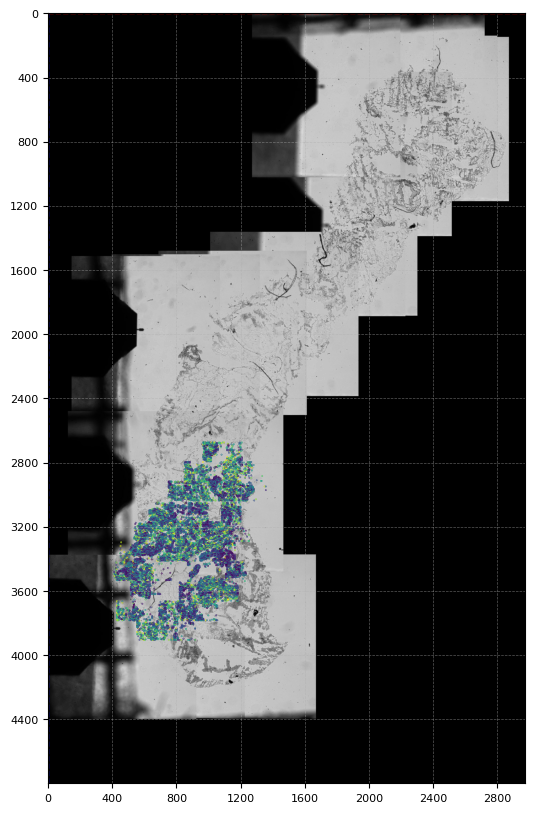

In [12]:
spatial_image = canvas2.copy()
canvas = np.zeros_like(canvas2)

# Draw the resized image on the canvas
canvas = cv2.addWeighted(canvas, 1, spatial_image, 1, 0)  # Overlay the image on the canvas

# Create a scatter plot on top of the canvas
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')  # Specify the grayscale colormap

plt.scatter(glass_filtered_afm['Y Position'], glass_filtered_afm['X Position'], 
                c=glass_filtered_afm["Young's Modulus [Pa]"], s=0.1)

plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

# Specify axis tick positions and labels
plt.xticks(np.arange(0, canvas.shape[1], step=400), fontsize=8)
plt.yticks(np.arange(0, canvas.shape[0], step=400), fontsize=8)

plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

plt.show()

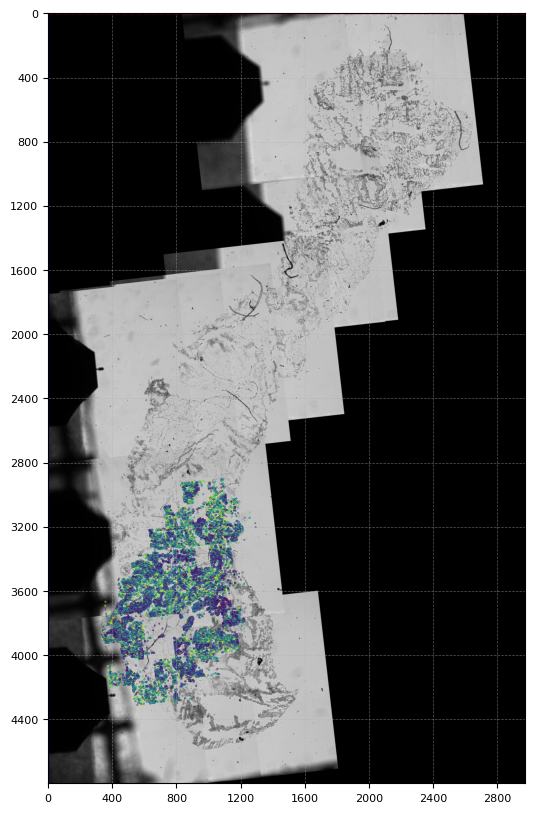

In [13]:
glass_filtered_afm = glass_filtered_afm.apply(apply_transformation, args=(sr,), axis=1)
spatial_image = cv2.warpPerspective(spatial_image, transformation_matrix, (mov.shape[1], mov.shape[0]))

canvas = np.zeros_like(canvas2)

# Draw the resized image on the canvas
canvas = cv2.addWeighted(canvas, 1, spatial_image, 1, 0)  # Overlay the image on the canvas

# Create a scatter plot on top of the canvas
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')  # Specify the grayscale colormap

plt.scatter(glass_filtered_afm['X'], glass_filtered_afm['Y'], 
                c=glass_filtered_afm["Young's Modulus [Pa]"], s=0.1)

plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

# Specify axis tick positions and labels
plt.xticks(np.arange(0, canvas.shape[1], step=400), fontsize=8)
plt.yticks(np.arange(0, canvas.shape[0], step=400), fontsize=8)

plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

plt.show()

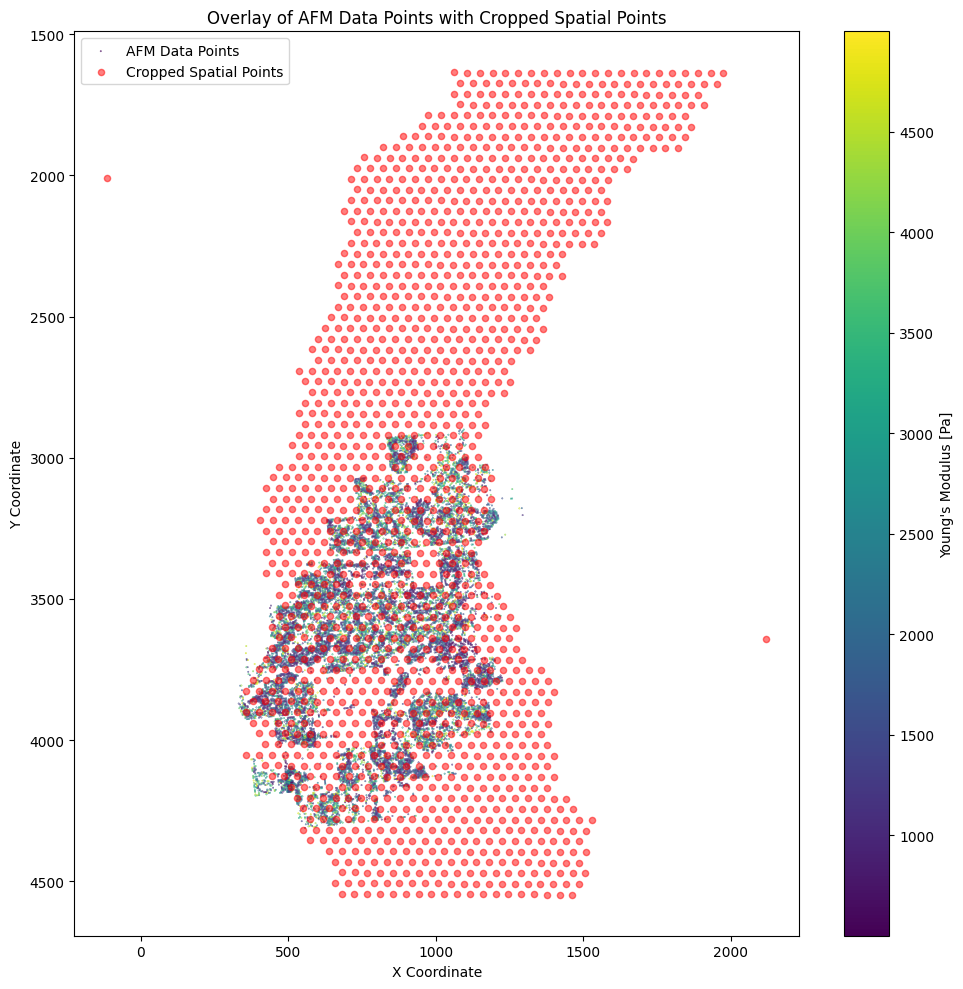

In [14]:
plt.figure(figsize=(10, 10))
scatter1 = plt.scatter(
    glass_filtered_afm['X'], 
    glass_filtered_afm['Y'], 
    c=glass_filtered_afm["Young's Modulus [Pa]"], 
    s=0.1, 
    cmap="viridis",
    label="AFM Data Points"
)

# Add a color bar for the modulus values
plt.colorbar(scatter1, label="Young's Modulus [Pa]")

# Overlay with the second scatter (cropped spatial points)
plt.scatter(
    spatial_coords_cropped[:, 0], 
    spatial_coords_cropped[:, 1], 
    s=20, 
    alpha=0.5, 
    color="red", 
    label="Cropped Spatial Points"
)

# Configure plot details
plt.gca().invert_yaxis()  # Invert y-axis to match orientation
plt.title("Overlay of AFM Data Points with Cropped Spatial Points")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Define the radius
radius = 12

# Create a KDTree for the AFM data points
afm_tree = cKDTree(glass_filtered_afm[['X', 'Y']].values)

# Initialize an empty list to store the average Young's modulus
average_modulus = []

# Iterate through all spatial coordinates
for coord in spatial_coords_cropped:
    # Find all AFM points within the specified radius of the current coordinate
    indices = afm_tree.query_ball_point(coord, r=radius)
    
    # If there are points in the radius, calculate the average modulus
    if indices:
        avg_mod = glass_filtered_afm.iloc[indices]["Young's Modulus [Pa]"].mean()
    else:
        avg_mod = np.nan  # Use NaN if no points are within the radius
    
    # Append the result to the list
    average_modulus.append(avg_mod)

# Add the results as a new column to the spatial_coords_cropped array
spatial_coords_cropped_with_modulus = pd.DataFrame(
    spatial_coords_cropped, columns=["X", "Y"]
)
spatial_coords_cropped_with_modulus['Average Young\'s Modulus [Pa]'] = average_modulus


spatial_coords_cropped_with_modulus.index = filtered_adata.obs.index

# Add the X, Y, and Average Young's Modulus [Pa] columns to filtered_adata.obs
filtered_adata.obs['X'] = spatial_coords_cropped_with_modulus['X']
filtered_adata.obs['Y'] = spatial_coords_cropped_with_modulus['Y']
filtered_adata.obs["Average Young's Modulus [Pa]"] = spatial_coords_cropped_with_modulus['Average Young\'s Modulus [Pa]']



spatial_coords_cropped_with_modulus[spatial_coords_cropped_with_modulus.fillna(0)["Average Young's Modulus [Pa]"] != 0]

filtered_adata_with_afm = filtered_adata[~(filtered_adata.obs["Average Young's Modulus [Pa]"].isna())]
filtered_adata_with_afm

View of AnnData object with n_obs × n_vars = 435 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden', 'total_counts', 'X', 'Y', "Average Young's Modulus [Pa]"
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'